# Imports

In [1]:
from sklearn.manifold import TSNE, MDS
from keras.models import load_model
from IPython.display import SVG, Audio, display
from keras.utils.vis_utils import model_to_dot
import numpy as np
import matplotlib.pyplot as plt
import librosa

/Users/sanmathikamath/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import sys
sys.path.append('../voicemap/')
sys.path.append('../')
from librispeech import LibriSpeechDataset
from utils import whiten, contrastive_loss
from config import LIBRISPEECH_SAMPLING_RATE
from voicemap.models import get_baseline_convolutional_encoder, build_siamese_net
from keras.optimizers import Adam

# Load and visualise pretrained model

In [3]:
#model_path = '../models/n_seconds/siamese__nseconds_3.0__filters_32__embed_64__drop_0.05__r_0.hdf5'
#model_path = '../models/siamese__filters_128__embed_64__drop_0.0__pad=True.hdf5'
#model_path = '../models_few_spkrs/siamese__filters_128__embed_64__drop_0.0__pad=True.hdf5'
#model_path = '../model_e35/siamese__filters_128__embed_64__drop_0.0__pad=True.hdf5'
n_seconds = 3
downsampling = 4
batchsize = 64
filters = 128
embedding_dimension = 64
dropout = 0.0
input_length = int(LIBRISPEECH_SAMPLING_RATE * n_seconds / downsampling)


In [4]:
encoder = get_baseline_convolutional_encoder(filters, embedding_dimension, dropout=dropout)
siamese = build_siamese_net(encoder, (input_length, 1), distance_metric='uniform_euclidean')
opt = Adam(clipnorm=1.)
siamese.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
#siamese = load_model(model_path)
siamese.load_weights('../all_models/model_e35/weights.hdf5')

Instructions for updating:
Colocations handled automatically by placer.


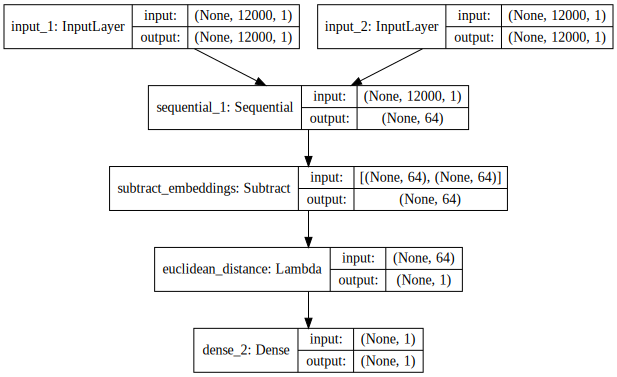

In [5]:
SVG(model_to_dot(siamese, show_shapes=True).create(prog='dot', format='svg'))

# Extract encoder
This extracts the encoder network that maps a single sample to a low dimensional space from the siamese network that takes two inputs.

In [6]:
from keras.models import Model
from keras.layers import Input

In [7]:
inputs = Input(shape=(12000,1))

encoded = siamese.layers[2](inputs)

In [8]:
encoder = Model(inputs=inputs, outputs=encoded)

In [9]:
encoder = siamese.layers[2]
encoder.compile(loss='mse',optimizer='adam')

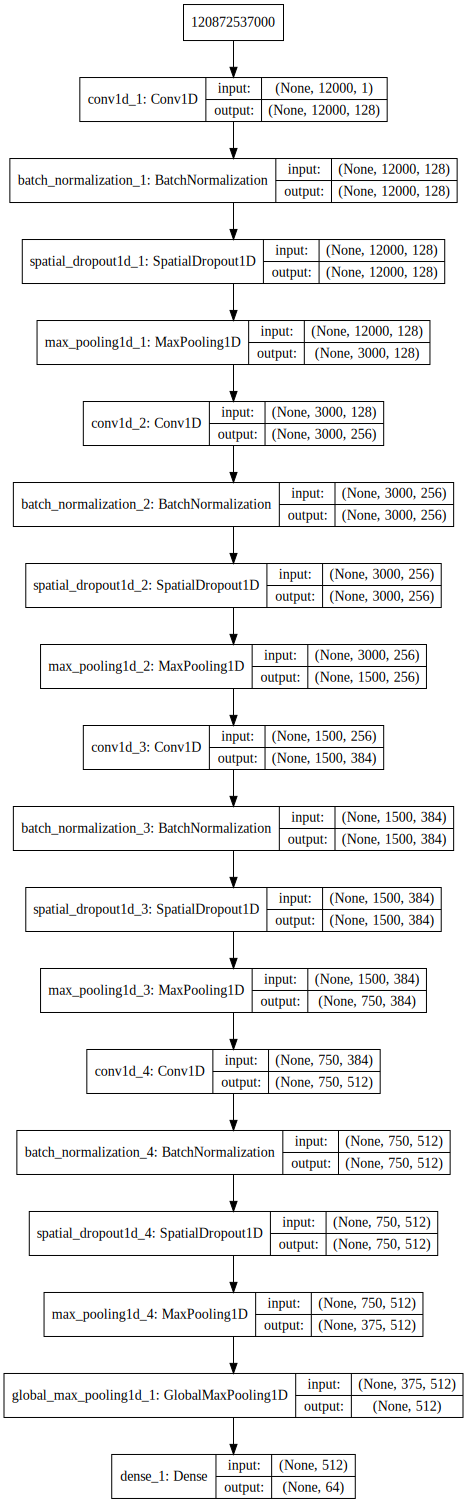

In [10]:
SVG(model_to_dot(encoder, show_shapes=True).create(prog='dot', format='svg'))

# Get data

In [11]:
def preprocessor(downsampling, whitening=True):
    def preprocessor_(batch):
        ([i_1, i_2], labels) = batch
        i_1 = i_1[:, ::downsampling, :]
        i_2 = i_2[:, ::downsampling, :]
        if whitening:
            i_1, i_2 = whiten(i_1), whiten(i_2)

        return [i_1, i_2], labels

    return preprocessor_


whiten_downsample = preprocessor(downsampling, whitening=True)

In [12]:
training_set = ['train-clean-100', 'train-clean-360']
train = LibriSpeechDataset(training_set, 3, stochastic=False,pad=True)#, cache=False)
validation_set = ['dev-clean']
valid = LibriSpeechDataset(validation_set, 3, stochastic=False, pad=True)#,cache=False)


Initialising LibriSpeechDataset with minimum length = 3s and subsets = ['train-clean-100', 'train-clean-360']
Finished indexing data. 132456 usable files found.
Initialising LibriSpeechDataset with minimum length = 3s and subsets = ['dev-clean']
Finished indexing data. 2703 usable files found.


### Random samples from subset of speakers

In [51]:
n_speakers = 20
m_samples = 10
n_random_speakers = valid.df['speaker_id'].sample(n_speakers).values
#n_random_speakers=[6345, 7850, 7976, 8297]
#n_random_speakers=np.array([ 19,  26,  39,  40,  78,  83, 125, 150, 163, 196, 198, 200, 201, 211, 229, 233, 84,174,251,422])
n_random_speakers = np.array([  84,  174,  251,  422,  652,  777, 1272, 1462, 1673, 1919, 1988,
       1993, 2035, 2078, 2086, 2277, 2412, 2428, 2803, 2902])

In [52]:
np.unique(valid.df['speaker_id'].values)[0:20]
n_random_speakers.shape

(20,)

In [53]:
# Get m samples from each speaker
import pdb
def _get_m_samples_from_n_speakers(m_samples, n_random_speakers, valid):
    X, y, indexes = [], [], []
    for i in n_random_speakers:
        ids = valid.df[valid.df['speaker_id']==i]['id'].sample(m_samples).values
        #pdb.set_trace()
        Z = [train[i] for i in ids]
        X_ = np.stack(list(zip(*Z))[0])[:, :, np.newaxis]
        y_ = np.stack(list(zip(*Z))[1])[:, np.newaxis]
        [X_, _], _ = whiten_downsample(([X_, X_], []))

        X.append(X_)
        y.append(y_[:, 0])
        indexes.append(ids)
        #pdb.set_trace()
    X = np.concatenate(X)
    y = np.concatenate(y)
    indexes = np.concatenate(indexes)
    return X, y, indexes
X, y, indexes=_get_m_samples_from_n_speakers(m_samples, n_random_speakers, valid)

In [16]:
# print(X.shape, y[1], indexes[1])
# train.df[train.df['speaker_id']== 1001]
# n_random_speakers
# l=valid.df['speaker_id']
# print(l,l.values)

# Embed

In [54]:
embeddings = encoder.predict(X)
embeddings.shape

(200, 64)

In [18]:
from voicemap.utils import BatchPreProcessor, preprocess_instances, NShotEvaluationCallback
batchsize=64
batch_preprocessor = BatchPreProcessor('siamese', preprocess_instances(downsampling))
valid_generator = (batch_preprocessor(batch) for batch in valid.yield_verification_batches(batchsize))

In [19]:
y_pred=siamese.predict_generator(valid_generator, steps=1, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)

1/1 [==============================] - 7s 7s/step


In [20]:
#siamese.predict([X[0], X[1]], 1], batch_size=None, verbose=0, steps=None)

# Dimensionality Reduction

In [21]:
def compare_samples(a, b):
    sample_a = train[a]
    sample_b = train[b]

    print('Sample A ({}):'.format(a))
    display(Audio(data=sample_a[0],rate=LIBRISPEECH_SAMPLING_RATE))
    print('Sample B ({}):'.format(b))
    display(Audio(data=sample_b[0],rate=LIBRISPEECH_SAMPLING_RATE))

In [59]:
tsne = TSNE(perplexity=30,learning_rate=1000, early_exaggeration=1)

tsne_embeddings = tsne.fit_transform(embeddings)
tsne_embeddings.shape

(200, 2)

In [60]:
gender_markers = np.array([0 if train.df[train.df['id']==i]['sex'].values[0] == 'M' else 1 for i in indexes])

In [61]:
Z = np.hstack([tsne_embeddings, y[:, np.newaxis], gender_markers[:, np.newaxis]])
m = Z[Z[:, 3] == 0]
f = Z[Z[:, 3] == 1]
m.shape, f.shape

((60, 4), (140, 4))

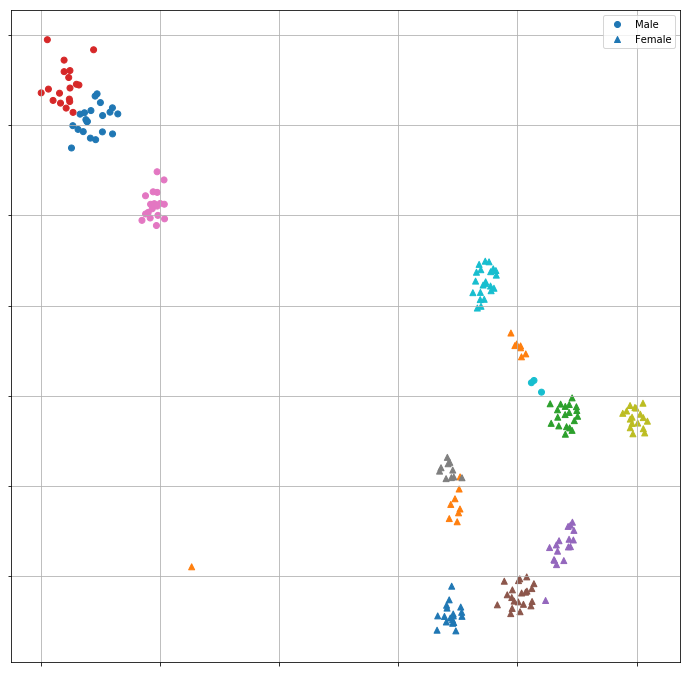

In [63]:
plt.figure(figsize=(12,12))

ax = plt.axes()
ax.scatter(m[:, 0], m[:, 1], c=[np.unique(m[:, 2]).tolist().index(i) for i in m[:, 2]], 
           marker='o', cmap='tab10')
ax.scatter(f[:, 0], f[:, 1], c=[np.unique(f[:, 2]).tolist().index(i) for i in f[:, 2]], 
           marker='^', cmap='tab10')

# Uncomment this block to show indexes of the samples in the dataset
#for x_, y_, idx, speaker_id in zip(Z[:, 0], Z[:, 1], indexes, y):
    #if np.random.random() < 0.025:
#   plt.text(x_, y_, idx)

ax.axes.set_xticklabels([])
ax.axes.set_yticklabels([])
plt.grid()
plt.legend(('Male', 'Female'),loc=1)
plt.savefig("Cluster5.png", dpi=250)
plt.show()

In [ ]:
Z[:,2][0:5], indexes[0:5], y[0:5]

## Outliers/Misclassified

In [ ]:
compare_samples(1487, 1594)

In [ ]:
compare_samples(838, 2214) 

# KNN Classifier 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
n_speakers = 20
m_samples = 10
n_random_speakers = train.df['speaker_id'].sample(n_speakers).values
X_train, y_train, indexes=_get_m_samples_from_n_speakers(m_samples, n_random_speakers, train)
embeddings = encoder.predict(X_train)
embeddings.shape

In [ ]:
# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 1)
# Fit the classifier to the data
knn.fit(embeddings,y_train)
print(knn.score(embeddings, y_train))

In [ ]:
##Testing
n_random_speakers = valid.df['speaker_id'].sample(n_speakers).values
X_valid, y_valid, indexes=_get_m_samples_from_n_speakers(m_samples, n_random_speakers, valid)
embeddings_valid = encoder.predict(X_valid)

In [ ]:
y_pred=knn.predict(embeddings_valid)
print(knn.score(embeddings_valid, y_valid))

In [ ]:
#print(y_pred, y_valid)

# DBSCAN

In [ ]:

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics

In [ ]:
db = DBSCAN(eps=1.1, min_samples=4)
y_pred=db.fit_predict(tsne_embeddings)

In [ ]:
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
n_clusters_


In [ ]:
labels

In [ ]:
y_pred2= db.labels_.astype(np.int)


In [ ]:
plt.figure(figsize=(12,12))

ax = plt.axes()
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:, 1], c=[np.unique(y_pred2).tolist().index(i) for i in y_pred2], 
           marker='o', cmap='tab10')

#Uncomment this block to show indexes of the samples in the dataset
#for x_, y_, idx, speaker_id in list(zip(Z[:, 0], Z[:, 1], indexes, y)):
    #if np.random.random() < 0.025:
    #plt.text(x_, y_, idx)
#centers = db.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
ax.axes.set_xticklabels([])
ax.axes.set_yticklabels([])
#ax.legend()
plt.grid()
plt.show()

# Accuracy

In [ ]:
from voicemap.utils import preprocess_instances,n_shot_task_evaluation, NShotEvaluationCallback, BatchPreProcessor

In [ ]:
#ns=NShotEvaluationCallback(10, 1, 5, valid, batch_preprocessor)
n_task=15
n_shot=1
k_way=5
n_correct=n_shot_task_evaluation(siamese, valid, batch_preprocessor, n_task, n_shot, k_way, network_type='siamese', distance='euclidean')

In [ ]:
acc=n_correct/n_task
acc

In [ ]:
#ns=NShotEvaluationCallback(10, 1, 5, valid, batch_preprocessor)
n_task=15
n_shot=1
k_way=5
n_correct2=n_shot_task_evaluation(encoder, valid, batch_preprocessor, n_task, n_shot, k_way, network_type='classifier', distance='euclidean')

In [ ]:
acc2=n_correct2/n_task
acc2

In [ ]:
y_pred2[0:5], Z[:,2][0:5], indexes[0:5], y[0:5]


In [ ]:
c=[np.unique(Z[:, 2]).tolist().index(i) for i in Z[:, 2]]
y_pred

# Logistic Regression Classifier 